In [1]:
from datetime import datetime, timedelta
import polars as pl
import pandas as pd
import os

#Adjust to fit your folder path
path = os.getcwd()
df = pl.scan_parquet(path+'\\rplace_pos.parquet')

In [2]:
df

<LazyFrame [8 cols, {"timestamp": Datetime(time_unit='ms', time_zone=None) … "y_rel": Float64}] at 0x1F6EC4F7500>

# Sorting time group chunks by STD

In [3]:
# Define the number of minutes for grouping, kind of arbitrary but 2 minutes was the shotbow
n_minutes = 2
# Define the time interval for grouping (e.g., 5 minutes)
interval = pd.Timedelta(minutes=n_minutes)

In [4]:
#Datetime when whole event started
start_time = datetime(2023,7,20,13,0,26,88)

In [5]:
# Create a new column to store the time group number
df = df.with_columns(((pl.col("timestamp") - start_time) // interval).cast(pl.Int64).alias("timestamp_group"))

In [6]:
#group by time group
#get means, std of relative position
t = df.group_by(["timestamp_group"]).agg(
    pl.mean("x").alias("mean_x"),
    pl.mean("y").alias("mean_y"),
    pl.mean("x_rel").alias("mean_x_rel"),
    pl.std("x_rel").alias("std_x_rel"),
    pl.mean("y_rel").alias("mean_y_rel"),
    pl.std("y_rel").alias("std_y_rel"),
    pl.count('x').alias('pixel_count')).sort(['std_x_rel','std_y_rel'], descending=False).collect(streaming=True)

In [7]:
t = t.to_pandas()
t

,timestamp_group,mean_x,mean_y,mean_x_rel,std_x_rel,mean_y_rel,std_y_rel,pixel_count
0,1,-59.750000,15.750000,-0.059750,0.152248,0.015750,0.184948,4
1,0,-107.111111,-104.888889,-0.107111,0.171741,-0.104889,0.157036,9
2,3776,9.454565,181.675793,0.003152,0.192707,0.090838,0.172041,106361
3,3819,14.418672,-201.547397,0.004806,0.197120,-0.100774,0.237571,71882
4,3827,-214.909294,299.345521,-0.071636,0.200808,0.149673,0.196932,136750
...,...,...,...,...,...,...,...,...
3855,1703,-37.967023,80.923429,-0.018984,0.363227,0.080923,0.266030,49823
3856,1681,-87.970631,100.850010,-0.043985,0.365934,0.100850,0.244324,57204
3857,1678,83.523159,119.053108,0.041762,0.366809,0.119053,0.256960,53909
3858,1682,-50.147254,70.950610,-0.025074,0.375312,0.070951,0.239199,54586


In [8]:
def add_mins(minute):
    return start_time + timedelta(minutes=(minute+1)*2)
def start_mins(minute):
    return start_time - timedelta(minutes=2) +timedelta(minutes=(minute+1)*2)

In [9]:
t['start_timestamp'] = t['timestamp_group'].apply(start_mins)
t['end_timestamp'] = t['timestamp_group'].apply(add_mins)

In [10]:
#Saving this information for later use
path = os.getcwd()
t.to_csv(path+'bot_coordinates.csv',index=False)

# Getting and storing the top 100 low STD times

In [11]:
t.sort_values(by=['std_x_rel','std_y_rel'])[0:100][['start_timestamp','end_timestamp']]

,start_timestamp,end_timestamp
0,2023-07-20 13:02:26.000088,2023-07-20 13:04:26.000088
1,2023-07-20 13:00:26.000088,2023-07-20 13:02:26.000088
2,2023-07-25 18:52:26.000088,2023-07-25 18:54:26.000088
3,2023-07-25 20:18:26.000088,2023-07-25 20:20:26.000088
4,2023-07-25 20:34:26.000088,2023-07-25 20:36:26.000088
...,...,...
95,2023-07-21 03:18:26.000088,2023-07-21 03:20:26.000088
96,2023-07-21 00:00:26.000088,2023-07-21 00:02:26.000088
97,2023-07-23 22:48:26.000088,2023-07-23 22:50:26.000088
98,2023-07-23 16:18:26.000088,2023-07-23 16:20:26.000088


In [12]:
t = pd.read_csv(path+'bot_coordinates.csv')

In [13]:
n = 100
top_potentials = t[t['pixel_count'] > 2000].sort_values(by=['std_x_rel','std_y_rel'])[0:n].sort_values(by='timestamp_group')

In [14]:
top_potentials

,timestamp_group,mean_x,mean_y,mean_x_rel,std_x_rel,mean_y_rel,std_y_rel,pixel_count,start_timestamp,end_timestamp
61,328,70.633912,128.578139,0.070634,0.251558,0.128578,0.266813,29441,2023-07-20 23:56:26.000088,2023-07-20 23:58:26.000088
42,329,69.595245,117.074898,0.069595,0.242668,0.117075,0.270676,30201,2023-07-20 23:58:26.000088,2023-07-21 00:00:26.000088
96,330,77.433076,98.521565,0.077433,0.258044,0.098522,0.260155,28286,2023-07-21 00:00:26.000088,2023-07-21 00:02:26.000088
47,331,77.022995,123.960908,0.077023,0.246122,0.123961,0.258874,30006,2023-07-21 00:02:26.000088,2023-07-21 00:04:26.000088
80,332,67.413133,105.111529,0.067413,0.254807,0.105112,0.261075,26316,2023-07-21 00:04:26.000088,2023-07-21 00:06:26.000088
...,...,...,...,...,...,...,...,...,...,...
15,3823,278.965429,-222.063003,0.092988,0.226200,-0.111032,0.236671,73124,2023-07-25 20:26:26.000088,2023-07-25 20:28:26.000088
46,3824,355.065632,-202.751288,0.118355,0.245485,-0.101376,0.242660,68336,2023-07-25 20:28:26.000088,2023-07-25 20:30:26.000088
4,3827,-214.909294,299.345521,-0.071636,0.200808,0.149673,0.196932,136750,2023-07-25 20:34:26.000088,2023-07-25 20:36:26.000088
11,3828,353.560717,346.449192,0.117854,0.213131,0.173225,0.191984,215144,2023-07-25 20:36:26.000088,2023-07-25 20:38:26.000088


In [15]:
#Writing to a csv for this data
for row in range(n):
    start,end = top_potentials[['start_timestamp','end_timestamp']].iloc[row]
    try:
        start = datetime.strptime(start,'%Y-%m-%d %H:%M:%S.%f')
    except:
        pass
    try:
        end = datetime.strptime(end,'%Y-%m-%d %H:%M:%S.%f')
    except:
        pass
    temp_df = df.filter((pl.col('timestamp') >= start) & (pl.col('timestamp') <= end)).collect(streaming=True).to_pandas()
    temp_df = temp_df[['timestamp','user','pixel_color','x','y','geometry']]
    if row == 0:
        temp_df.to_csv(path+'test.csv', mode='w', index=False, header=True)
    else:
        temp_df.to_csv(path+'test.csv', mode='a', index=False, header=False)
    print(row)

0
1
2
3


# CSV top 100 data to Parquet

In [ ]:
import pyarrow.csv as csv
import pyarrow.parquet as pq
import pyarrow as pa
from pyarrow import parquet
import os
import pandas as pd
import re

In [ ]:
source_directory = path
output_parquet_file = "top 100 low spread.parquet"

# Define schema for parquet
schema = pa.schema([
    pa.field("timestamp", pa.timestamp(unit='ms')),
    pa.field("user", pa.string()),
    #pa.field("coordinate", pa.string()),
    pa.field("pixel_color", pa.string()),
    pa.field("x", pa.int16()),
    pa.field("y", pa.int16()),
    pa.field("geometry", pa.int16())
])
# Initialize parquet writer
writer = parquet.ParquetWriter(output_parquet_file, schema, compression="snappy")

# Join source directory with current filename
path_to_file = os.path.join(source_directory, 'top 100 low spread times.csv')

# Read current csv        
print("Reading: " + 'top 100 low spread times.csv')
table = csv.read_csv(path_to_file)
'''
#Ensuring the date is in the proper format, requires removing UTC and redefining as timestamp in milliseconds
array = table['timestamp'].combine_chunks()
# Replace string ending with UTC
array = pa.compute.replace_substring_regex(array, " UTC", "")
# Convert to date
array = array.cast(pa.timestamp(unit='ms'))
# Put back in the table
table = table.set_column(table.schema.get_field_index("timestamp"), "timestamp", array)
'''

table = table.cast(schema)

# Write current csv to parquet
print("Writing: " + 'top 100 low spread times.csv')
writer.write_table(table)

# Close parquet writer if still open
if writer:
    writer.close()


print("Successfully combined into " + output_parquet_file)

# Making graphics

In [7]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import os
import math
import datetime
import numpy as np

path = os.getcwd()
df = pl.scan_parquet(path+'\\top 100 low spread.parquet')

In [3]:
# Sort DataFrame by timestamp
data = df.collect(streaming=True).to_pandas().sort_values(by='timestamp',ignore_index=True)

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
#Make y flipped right side up
data['y'] = -data['y']
#Get a shifted coord column for use in lists/graphs
data['x_shift'] = data['x'] + 1499
data['y_shift'] = data['y'] + 999

In [4]:
#Useful for graphing
def hex_to_rgb(hex_color):
    # Convert hex color code to RGB tuple
    hex_color = hex_color.lstrip('#')
    return np.array(list(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))

## Just an image of the whole thing

<Figure size 640x480 with 0 Axes>

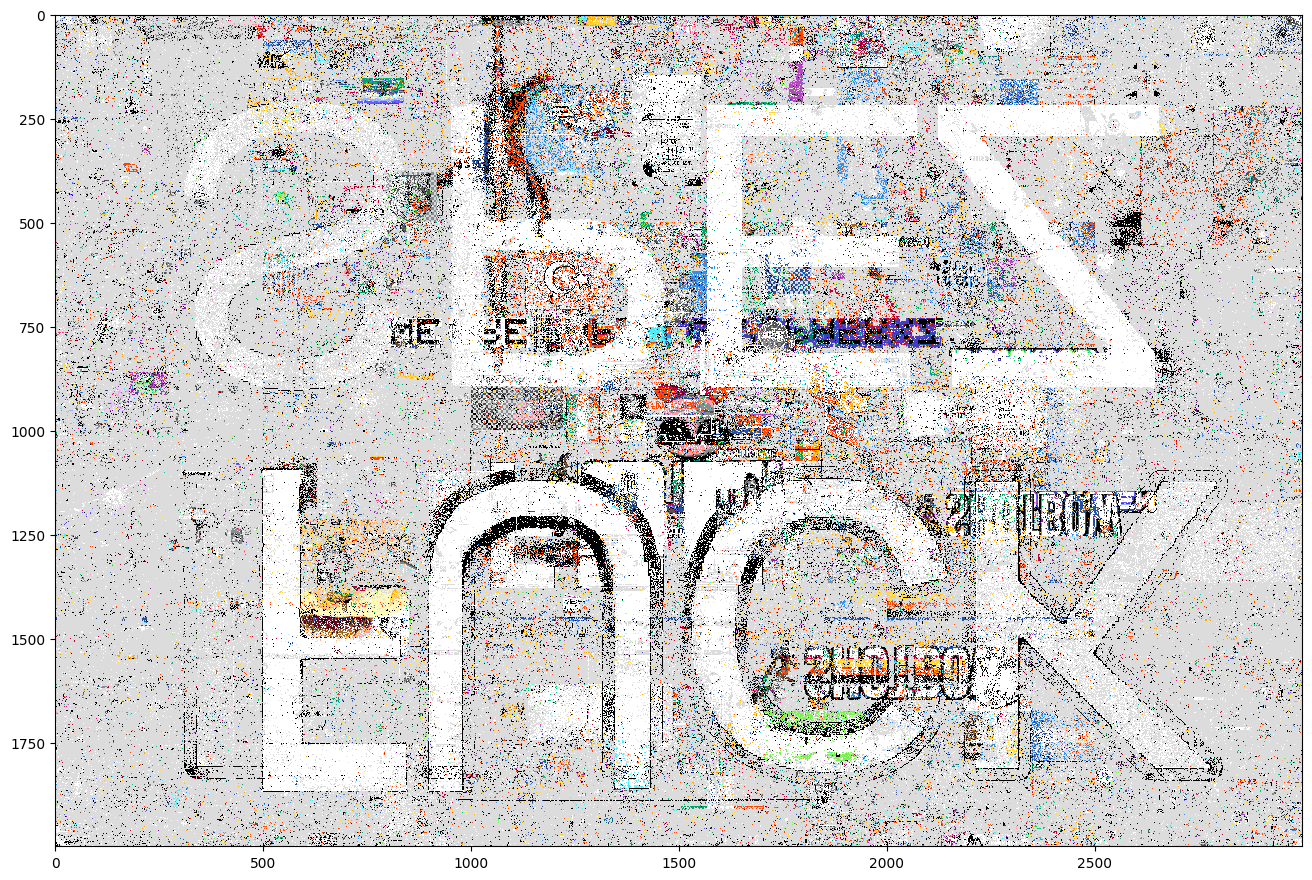

In [5]:
#Note, this takes a while unsure how long though
import numpy as np 
import matplotlib.pyplot as plt 

#Setting a gray grid of size 2000x3000 (y,x) ((sorry)) each with a size 3 list/tuple of (R,G,B) for color
grid_data = np.full((2000, 3000, 3), (220,220,220))
for row in range(len(data)):
    #Adjusting this particular coordinate by it's actual pixel color 
    grid_data[data['y_shift'][row]][data['x_shift'][row]] = hex_to_rgb(data['pixel_color'][row])

# creating a plot
pixel_plot = plt.figure() 

# Adjusting the size of the plot
plt.figure(figsize=(19.20, 10.80),dpi=100)

# Adjusting the x-axis and y-axis tick labels
# Setting x-axis and y-axis ticks
#plt.xticks(np.arange(-1500, 1501, 500))
#plt.yticks(np.arange(-1000, 1001, 500))

# customizing plot
pixel_plot = plt.imshow(grid_data,interpolation='nearest') 
# show plot 
plt.show(pixel_plot)

## Animation

MovieWriter ffmpeg unavailable; using Pillow instead.


saving
....................................................................................................

ValueError: unknown file extension: .mp4

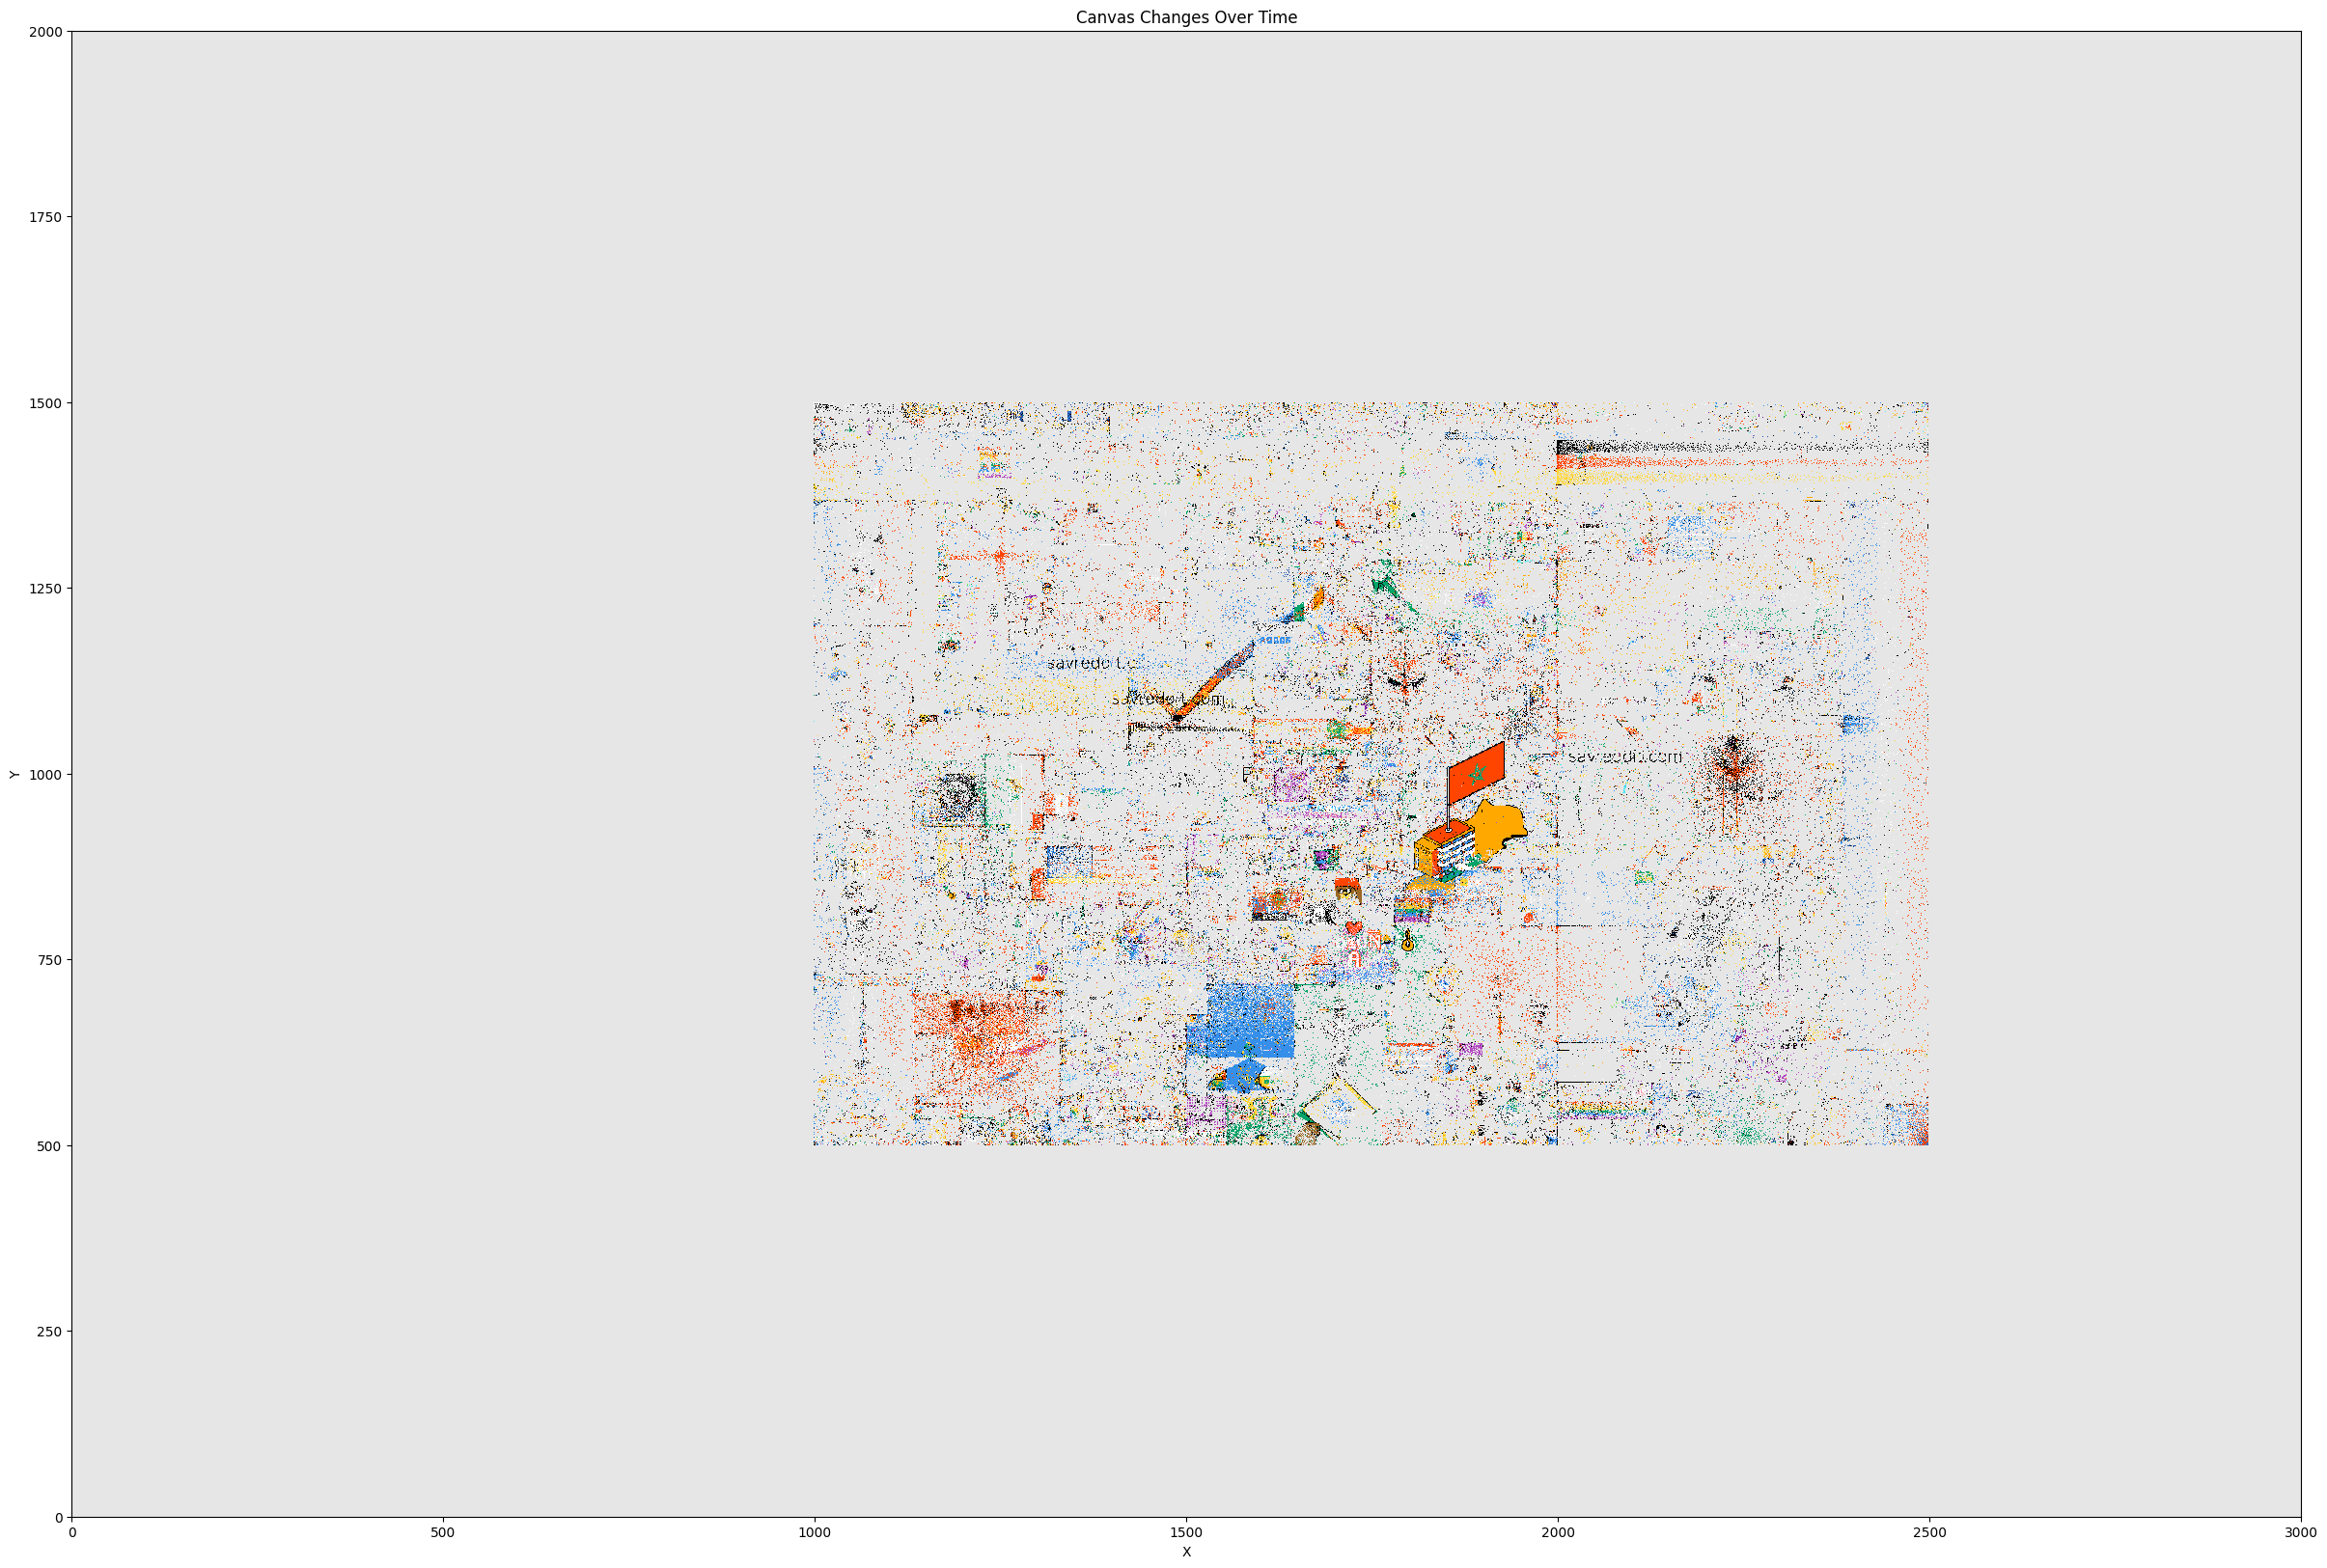

In [8]:
now = datetime.datetime.now()
# Adjusting the size of the plot
fig = plt.figure(figsize=(30.0, 20.0), dpi=100) #This effectively draws a 3000x2000 plot assuming a dots per inch of 100. If you go lower you might not see pixels you change in frames

#Takes first 500,000 data points, can do more or less
subdata = data[0:500000]
#Same grid as image 
grid_data = np.full((2000, 3000, 3), (230,230,230)) #makes it grey (220,220,220)

# Initialize plot
im = plt.imshow(grid_data, interpolation='nearest')

#Function to set up the start of the plot
def init():
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Canvas Changes Over Time')
    plt.xlim(0, 3000)  # Adjust x-axis limits as needed
    plt.ylim(0, 2000)  # Adjust y-axis limits as needed
    im.set_data(grid_data)
    return [im]
    
# Function to update plot for each 'frame'
def update(frame):
    #Loop through and place group_size amount of colored pixels, then call that the next 'frame' in the video
    for i in range(group_size):
        #grabbing x,y,color and placing into corresponding location in image data grid
        x = subdata['x_shift'][i + frame*group_size]
        y = subdata['y_shift'][i + frame*group_size]
        hex_code = subdata['pixel_color'][i + frame*group_size]
        rgb_code = hex_to_rgb(hex_code)
        grid_data[y][x] = rgb_code
    if frame%10 == 0:
        print('.',end='')
    im.set_data(grid_data)
    return [im]

# Calculate frames for the animation
#frames per second, kinda arbitrary but higher means shorter video
fps = 60
#Arbitrary amount of pixels to adjust per frame of the video
group_size=500

# Create animation
#fig is the figure, update is the function that uses the frame value to update and store a new frame
#frames is just a number and frame values 0 -> frames passed to update function
#interval is time in ms to wait between drawing next frame in video
#blit tries to only draw the diffs between frames --- if True then update/init functions need to return a list
ani = FuncAnimation(fig, update, init_func=init, frames=int(len(subdata)/group_size), interval=int(1000/fps), blit=True)

# Save the animation
from matplotlib import animation

#You have to download this and save it to your PATH on windows, mac process unsure
writer = animation.FFMpegWriter(fps=fps)
print('saving')

ani.save('testes2.mp4') #or whatever you want to call it
print('done')
#plt.show()
print(datetime.datetime.now() - now)